# Pre-Processing of TREC data set and TSNE visualization

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from bs4 import BeautifulSoup
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## [1]. Reading Data

In [4]:
file_encoding = 'cp1252'

train_url = 'https://raw.githubusercontent.com/CS287/HW1/master/data/TREC.train.all'
test_url='https://raw.githubusercontent.com/CS287/HW1/master/data/TREC.test.all'
df_train = pd.read_csv(train_url,names=['code'],encoding=file_encoding)
df_test = pd.read_csv(test_url,names=['code'],encoding=file_encoding)
df_train[['label','text']] = df_train["code"].str.split(" ", 1,expand=True)
df_test[['label','text']] = df_train["code"].str.split(" ", 1,expand=True)



In [5]:
df_train

,code,label,text
0,0 How did serfdom develop in and then leave Ru...,0,How did serfdom develop in and then leave Russ...
1,1 What films featured the character Popeye Doy...,1,What films featured the character Popeye Doyle ?
2,0 How can I find a list of celebrities ' real ...,0,How can I find a list of celebrities ' real na...
3,1 What fowl grabs the spotlight after the Chin...,1,What fowl grabs the spotlight after the Chines...
4,2 What is the full form of .com ?,2,What is the full form of .com ?
...,...,...,...
5447,1 What 's the shape of a camel 's spine ?,1,What 's the shape of a camel 's spine ?
5448,1 What type of currency is used in China ?,1,What type of currency is used in China ?
5449,5 What is the temperature today ?,5,What is the temperature today ?
5450,5 What is the temperature for cooking ?,5,What is the temperature for cooking ?


In [6]:
df_test

,code,label,text
0,5 How far is it from Denver to Aspen ?,0,How did serfdom develop in and then leave Russ...
1,4 What county is Modesto,1,What films featured the character Popeye Doyle ?
2,3 Who was Galileo ?,0,How can I find a list of celebrities ' real na...
3,0 What is an atom ?,1,What fowl grabs the spotlight after the Chines...
4,5 When did Hawaii become a state ?,2,What is the full form of .com ?
...,...,...,...
495,3 Who was the 22nd President of the US ?,1,What is the Jewish bible called ?
496,1 What is the money they use in Zambia ?,0,Why is the grass green ?
497,5 How many feet in a mile ?,0,What is a firewall ?
498,1 What is the birthstone of October ?,3,What spy novelist served as Moscow corresponde...


In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(df_train.shape)

#How many positive and negative reviews are present in our dataset?
df_train['label'].value_counts()

(5452, 3)


1    1250
3    1223
0    1162
5     896
4     835
2      86
Name: label, dtype: int64

In [9]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bccuser04\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
df_train

,code,label,text
0,0 How did serfdom develop in and then leave Ru...,0,How did serfdom develop in and then leave Russ...
1,1 What films featured the character Popeye Doy...,1,What films featured the character Popeye Doyle ?
2,0 How can I find a list of celebrities ' real ...,0,How can I find a list of celebrities ' real na...
3,1 What fowl grabs the spotlight after the Chin...,1,What fowl grabs the spotlight after the Chines...
4,2 What is the full form of .com ?,2,What is the full form of .com ?
...,...,...,...
5447,1 What 's the shape of a camel 's spine ?,1,What 's the shape of a camel 's spine ?
5448,1 What type of currency is used in China ?,1,What type of currency is used in China ?
5449,5 What is the temperature today ?,5,What is the temperature today ?
5450,5 What is the temperature for cooking ?,5,What is the temperature for cooking ?


In [13]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df_train['text'].values):
    #print(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    #sentance = ' '.join(e.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 5452/5452 [00:01<00:00, 3377.10it/s]


In [14]:
df_train["CleanedText"]=preprocessed_reviews

In [15]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df_test['text'].values):
    #print(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    #sentance = ' '.join(e.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 3498.15it/s]


In [16]:
df_test["CleanedText"]=preprocessed_reviews

In [17]:
df_test

,code,label,text,CleanedText
0,5 How far is it from Denver to Aspen ?,0,How did serfdom develop in and then leave Russ...,serfdom develop leave russia
1,4 What county is Modesto,1,What films featured the character Popeye Doyle ?,films featured character popeye doyle
2,3 Who was Galileo ?,0,How can I find a list of celebrities ' real na...,find list celebrities real names
3,0 What is an atom ?,1,What fowl grabs the spotlight after the Chines...,fowl grabs spotlight chinese year monkey
4,5 When did Hawaii become a state ?,2,What is the full form of .com ?,full form com
...,...,...,...,...
495,3 Who was the 22nd President of the US ?,1,What is the Jewish bible called ?,jewish bible called
496,1 What is the money they use in Zambia ?,0,Why is the grass green ?,grass green
497,5 How many feet in a mile ?,0,What is a firewall ?,firewall
498,1 What is the birthstone of October ?,3,What spy novelist served as Moscow corresponde...,spy novelist served moscow correspondent reute...


# [2] Featurization

## [2.1] Word2Vec

In [18]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in df_train['CleanedText']:
    list_of_sentance.append(sentance.split())

In [19]:
 w2v_model_m=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

In [20]:
## using pretrained model by google Goole 

In [21]:
w2v_model_g=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [22]:
w2v_model_g.wv.most_similar('great')

[('terrific', 0.7989331483840942),
 ('fantastic', 0.7935211658477783),
 ('tremendous', 0.7748856544494629),
 ('wonderful', 0.7647868394851685),
 ('good', 0.7291510105133057),
 ('incredible', 0.7032873630523682),
 ('marvelous', 0.6971102952957153),
 ('phenomenal', 0.6841565370559692),
 ('amazing', 0.6634128093719482),
 ('awesome', 0.6510506868362427)]

In [23]:
w2v_model_m.wv.most_similar('great')

[('war', 0.7506715059280396),
 ('state', 0.740448534488678),
 ('first', 0.7369781732559204),
 ('many', 0.7337493896484375),
 ('one', 0.726367175579071),
 ('called', 0.7181605100631714),
 ('get', 0.7125192880630493),
 ('star', 0.7124421000480652),
 ('number', 0.6974789500236511),
 ('city', 0.6896657347679138)]

In [84]:
w2v_model_g.wv.most_similar('worst')

[('Worst', 0.6146092414855957),
 ('weakest', 0.6143776774406433),
 ('scariest', 0.5957258343696594),
 ('ugliest', 0.5931180715560913),
 ('best', 0.5835110545158386),
 ('bleakest', 0.5718506574630737),
 ('strongest', 0.567145586013794),
 ('nastiest', 0.5644308924674988),
 ('lousiest', 0.5631451606750488),
 ('toughest', 0.5624395608901978)]

In [85]:
w2v_model_g.wv.most_similar('computer')

[('computers', 0.7979379892349243),
 ('laptop', 0.6640493273735046),
 ('laptop_computer', 0.6548868417739868),
 ('Computer', 0.6473334431648254),
 ('com_puter', 0.6082079410552979),
 ('technician_Leonard_Luchko', 0.5662748217582703),
 ('mainframes_minicomputers', 0.5617721080780029),
 ('laptop_computers', 0.5585449934005737),
 ('PC', 0.5539618134498596),
 ('maker_Dell_DELL.O', 0.5519254207611084)]

In [86]:
w2v_model_m.wv.most_similar('computer')

[('dog', 0.5886861681938171),
 ('book', 0.5830365419387817),
 ('baseball', 0.5582056045532227),
 ('game', 0.5533534288406372),
 ('features', 0.5524148941040039),
 ('actor', 0.5507881045341492),
 ('singer', 0.5445547103881836),
 ('u', 0.5430641174316406),
 ('famous', 0.542276918888092),
 ('capital', 0.5409361124038696)]

In [87]:
w2v_model_m.wv.most_similar('great')

[('com', 0.7014347314834595),
 ('city', 0.6735042929649353),
 ('play', 0.6662961840629578),
 ('tv', 0.6653598546981812),
 ('much', 0.6550982594490051),
 ('name', 0.6521872878074646),
 ('known', 0.6435665488243103),
 ('many', 0.6424198150634766),
 ('book', 0.6399986147880554),
 ('new', 0.6375181674957275)]

In [24]:
w2v_model=w2v_model_g

In [25]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
#

number of words that occured minimum 5 times  3000000


In [29]:
df_train

,code,label,text,CleanedText
0,0 How did serfdom develop in and then leave Ru...,0,How did serfdom develop in and then leave Russ...,serfdom develop leave russia
1,1 What films featured the character Popeye Doy...,1,What films featured the character Popeye Doyle ?,films featured character popeye doyle
2,0 How can I find a list of celebrities ' real ...,0,How can I find a list of celebrities ' real na...,find list celebrities real names
3,1 What fowl grabs the spotlight after the Chin...,1,What fowl grabs the spotlight after the Chines...,fowl grabs spotlight chinese year monkey
4,2 What is the full form of .com ?,2,What is the full form of .com ?,full form com
...,...,...,...,...
5447,1 What 's the shape of a camel 's spine ?,1,What 's the shape of a camel 's spine ?,shape camel spine
5448,1 What type of currency is used in China ?,1,What type of currency is used in China ?,type currency used china
5449,5 What is the temperature today ?,5,What is the temperature today ?,temperature today
5450,5 What is the temperature for cooking ?,5,What is the temperature for cooking ?,temperature cooking


## [2.1.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

### [2.1.1.1] Avg W2v

In [26]:

def avgw2vvectors(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(300) # as word vectors are of zero length 200, you might need to change this to 300 if you use google's w2v
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [27]:
i=0
list_of_sentance_train=[]
for sentance in df_train['CleanedText']:
    list_of_sentance_train.append(sentance.split())

In [28]:
i=0
list_of_sentance_test=[]
for sentance in df_test['CleanedText']:
    list_of_sentance_test.append(sentance.split())

In [30]:
train_avgw2v=avgw2vvectors(list_of_sentance_train)


100%|██████████████████████████████████████████████████████████████████████████████| 5452/5452 [01:28<00:00, 61.29it/s]

5452
300


In [31]:
np.save('X_train_TREC_google_w2v.npy', train_avgw2v)

In [32]:
test_avgw2v=avgw2vvectors(list_of_sentance_test)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 66.64it/s]

500
300


In [33]:
np.save('X_test_TREC_google_w2v.npy', test_avgw2v)

In [34]:
###manual word2 vec model
X_train=train_avgw2v
X_test=test_avgw2v
y_train=df_train['label']
y_test=df_test['label']

In [35]:
np.save('y_test_TREC',y_test)
np.save('y_train_TREC',y_train)

## [3] TSNE Visualization

In [109]:
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = X_train
labels_1000 = y_train
#data= 
#labels= label


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df_bin = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

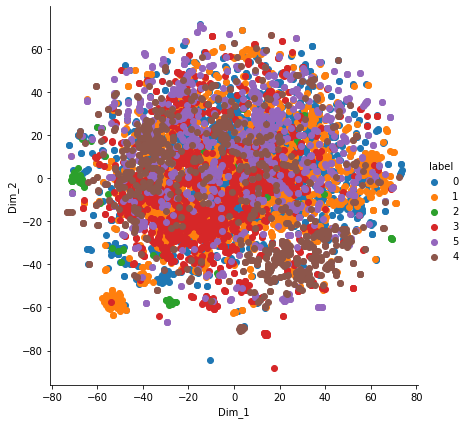

In [110]:
import seaborn as sns
sns.FacetGrid(tsne_df_bin, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [111]:
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = X_train[1:1000]
labels_1000 = y_train[1:1000]
#data= 
#labels= label


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df_bin = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

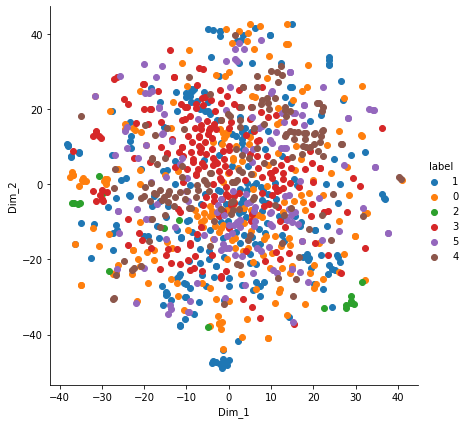

In [112]:
import seaborn as sns
sns.FacetGrid(tsne_df_bin, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()